In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
py.tools.set_credentials_file(username='tjogesh', api_key='jQCndI6d5M1oYF4mXX7i')

## ------------------------------------------------------
##  Read and merge the cleaned datasets
## ------------------------------------------------------

In [3]:
#read all the cleaned datasets
parcel_data_asses2014 =pd.read_csv('parcel_data_clean.csv')
#the two dbi datsets have already been combined based on complaint # 
dbi_viol =pd.read_csv('dbi_violations_clean.csv')
fire_viol =pd.read_csv('fire_violations_clean.csv')
fire_insp =pd.read_csv('fire_inspections_clean.csv')
fire_incidents =pd.read_csv('fire_incidents_clean.csv')

#remove irrelavent columns
to_remove = ['Unnamed: 0', 
                     'Unnamed: 0.1',
                     'Property Location', 
                     'Location',  
                     'blklot']
dbi_viol.drop(['Unnamed: 0', 'Unnamed: 0.1',
              'Property Location',
              'Location',
              'parcel'], axis=1, inplace=True)
fire_viol.drop(to_remove, axis=1, inplace=True)
fire_insp.drop(to_remove, axis=1, inplace=True)
fire_incidents.drop(to_remove, axis=1, inplace=True)
                     

In [4]:
#include information on whether or not a building recieved a DBI complaint, inspection or violation
dbi_viol['dbi_complaint_filed']=1 
fire_viol['fire_violation_reported']=1
fire_insp['fire_inspection_conducted']=1

In [5]:
# add a suffix prior to merge so I can trace back where these data came from
dbi_viol = dbi_viol.add_suffix('_dbi_viol')
fire_viol = fire_viol.add_suffix('_fire_viol')
fire_insp = fire_insp.add_suffix('_fire_insp')
fire_incidents = fire_incidents.add_suffix('_fire_incidents')

In [6]:
#use left joins to merge all datasets and I double checked that the final main_df has the same number of rows as the 
#parcel data
main_df =parcel_data_asses2014.merge(dbi_viol, left_on='Block and Lot Number', right_on='Block and Lot Number_dbi_viol', 
                                     how='left',)
main_df =main_df.merge(fire_viol, left_on='Block and Lot Number', right_on='Block and Lot Number_fire_viol', how='left')
main_df =main_df.merge(fire_insp, left_on='Block and Lot Number', right_on='Block and Lot Number_fire_insp', how='left')
main_df =main_df.merge(fire_incidents, left_on='Block and Lot Number', right_on='Block and Lot Number_fire_incidents', how='left')

#if no complaints or violations are filled at parcel AND no reported building fires then all values are 0 here
main_df.fillna(0,inplace=True) 

In [9]:
#check for duplicates
print(main_df.shape)
print(main_df.drop_duplicates('Block and Lot Number').shape)

(25481, 192)
(25481, 192)


In [13]:
#list(main_df.columns)

In [14]:
to_drop=['Block and Lot Number',
         'Block and Lot Number_dbi_viol',
         'Block and Lot Number_fire_viol',
         'Block and Lot Number_fire_insp',
         'Block and Lot Number_fire_incidents',
         'Unnamed: 0',
         'BuildingFire_fire_incidents',
         'Location']
features = main_df.drop(to_drop, axis=1)
fire = main_df['BuildingFire_fire_incidents']
fire[fire > 1] = 1 #some buildings have multiple fires

/Users/taniajogesh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [15]:
features.shape

(25481, 184)

In [16]:
fire.sum()/fire.count() #proportion of buildings with a history of fire

0.024214120324948001

## ------------------------------------------------------
##  MACHINE LEARNING CLASSIFIERS
## ------------------------------------------------------

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
import numpy as np

In [18]:
Y= fire.values
X =features.values
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

## Logistic Regression

In [23]:
# C= 0.01 is good here to increase regularization. There are a lot of features going into this model
# balanced weighting is also important because the the class sample sizes are fairly skewed
xtrain, xtest, ytrain, ytest = train_test_split(X_scale,Y, test_size=0.30)
logreg = LogisticRegression(penalty = 'l2', C=0.01, class_weight="balanced", solver ='sag', max_iter=1000) 
logregM = logreg.fit(xtrain, ytrain)
yscore = logregM.predict(xtest)
recall = recall_score(ytest, yscore)
training_accuracy = logregM.score(xtrain, ytrain)
test_accuracy = logregM.score(xtest, ytest)
average_precision = average_precision_score(ytest, yscore)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print("Recall score:     {:2f}".format(recall))
print("Average precision:     {:2f}".format(average_precision))

Accuracy on training data: 0.783752
Accuracy on test data:     0.784827
Recall score:     0.675978
Average precision:     0.377204


ROC AUC: 0.84


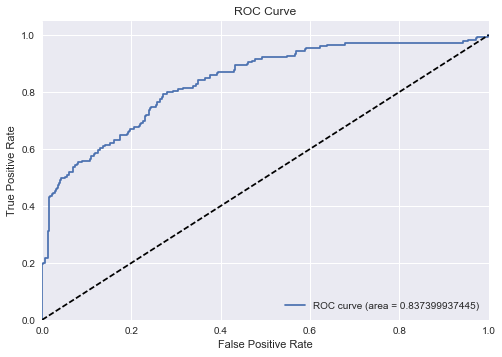

In [24]:
# Calculate the AUC
fpr, tpr, thresholds = roc_curve(ytest, logregM.predict_proba(xtest)[:,1])
roc_auc = auc(fpr, tpr)
print 'ROC AUC: %0.2f' % roc_auc

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

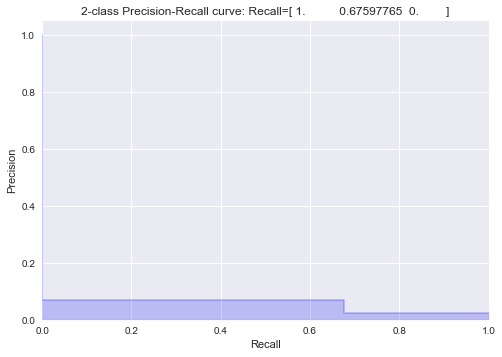

In [25]:
yscore = logregM.predict(xtest)
average_precision = average_precision_score(ytest, yscore)
recall = recall_score(ytest, yscore)
precision, recall, _ = precision_recall_curve(ytest, yscore)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: Recall={}'.format(
          recall))

#recall is good but precision is crap. Very precautionary model because high false positive rate

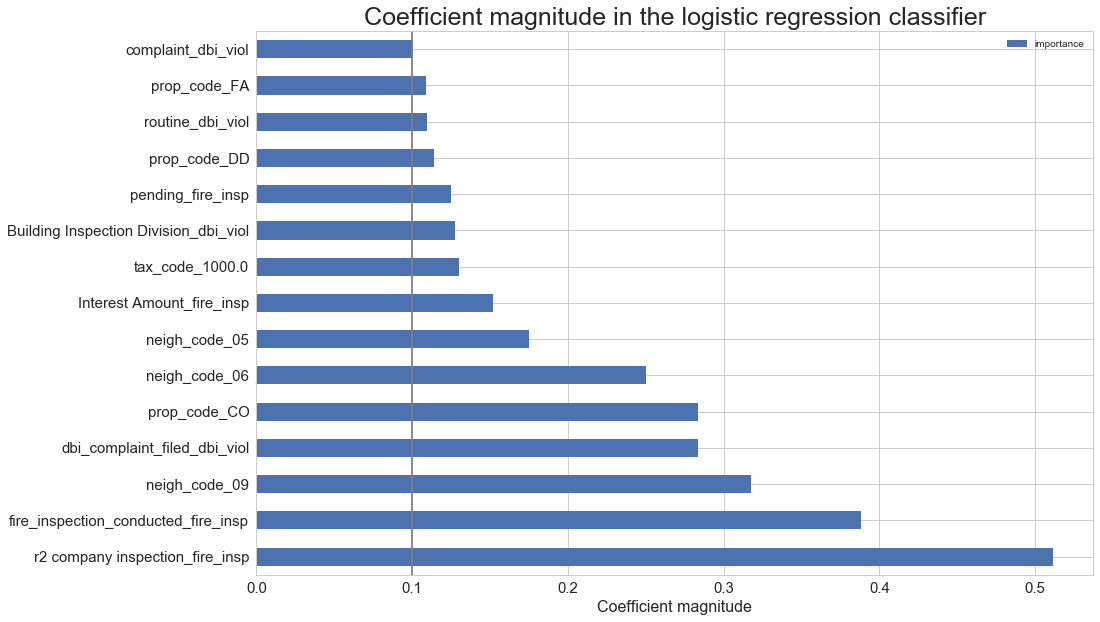

In [101]:
importances = logregM.coef_
feature_list = list(features.columns) 
feature_importance = pd.DataFrame(zip(feature_list, importances[0]), columns = ('feature','importance'))
feature_importance.set_index('feature', inplace=True)
feature_importance.sort_values('importance', ascending=False)[:15].plot(kind='barh', figsize=(15, 10))
plt.axvline(0.1, color="gray")
plt.title('Coefficient magnitude in the logistic regression classifier', fontsize = 25)
plt.xlabel('Coefficient magnitude', fontsize = 16)
plt.ylabel("")
ylabs= ['']
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()## Missing data

## Random Forest Model

In [27]:
xtrain, xtest, ytrain, ytest = train_test_split(X_scale,Y, test_size=0.30)
forest = RandomForestClassifier(n_estimators = 100, class_weight="balanced") 
forest = forest.fit(xtrain, ytrain)
yscore = forest.predict(xtest)
recall = recall_score(ytest, yscore)
training_accuracy = forest.score(xtrain, ytrain)
test_accuracy = forest.score(xtest, ytest)
average_precision = average_precision_score(ytest, yscore)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print("Recall score:     {:2f}".format(recall))
print("Average precision:     {:2f}".format(average_precision))

Accuracy on training data: 0.999944
Accuracy on test data:     0.984434
Recall score:     0.323864
Average precision:     0.669715


## Support Vector Machines

In [28]:
#scale the data because SVMs perform better on scaled data
#The grid search took a really long time to run so I manually serached through a range of values for now. 
#low gamma
xtrain, xtest, ytrain, ytest = train_test_split(X_scale,Y, test_size=0.50)
svc_clf = SVC(kernel='linear', C=1, gamma=0.001, class_weight="balanced") 
svc_model = svc_clf.fit(xtrain, ytrain)
training_accuracy = svc_model.score(xtrain, ytrain)
test_accuracy = svc_model.score(xtest, ytest)
yscore = svc_model.predict(xtest)
recall = recall_score(ytest, yscore)
average_precision = average_precision_score(ytest, yscore)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print("Recall score:     {:2f}".format(recall))
print("Average precision:     {:2f}".format(average_precision))

Accuracy on training data: 0.839089
Accuracy on test data:     0.834550
Recall score:     0.613003
Average precision:     0.356799


In [29]:
#default
xtrain, xtest, ytrain, ytest = train_test_split(X_scale,Y, test_size=0.50)
svc_clf = SVC(kernel='linear', C=1, gamma=1, class_weight="balanced") 
svc_model = svc_clf.fit(xtrain, ytrain)
training_accuracy = svc_model.score(xtrain, ytrain)
test_accuracy = svc_model.score(xtest, ytest)
yscore = svc_model.predict(xtest)
recall = recall_score(ytest, yscore)
average_precision = average_precision_score(ytest, yscore)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print("Recall score:     {:2f}".format(recall))
print("Average precision:     {:2f}".format(average_precision))

Accuracy on training data: 0.791523
Accuracy on test data:     0.785967
Recall score:     0.633898
Average precision:     0.354509


In [30]:
# low C (higher regularization) default gamma
xtrain, xtest, ytrain, ytest = train_test_split(X_scale,Y, test_size=0.50)
svc_clf = SVC(kernel='linear', C=0.001, gamma=1, class_weight="balanced") 
svc_model = svc_clf.fit(xtrain, ytrain)
training_accuracy = svc_model.score(xtrain, ytrain)
test_accuracy = svc_model.score(xtest, ytest)
yscore = svc_model.predict(xtest)
recall = recall_score(ytest, yscore)
average_precision = average_precision_score(ytest, yscore)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print("Recall score:     {:2f}".format(recall))
print("Average precision:     {:2f}".format(average_precision))

Accuracy on training data: 0.846860
Accuracy on test data:     0.848285
Recall score:     0.603774
Average precision:     0.354855


In [31]:
# low C and low gamma
xtrain, xtest, ytrain, ytest = train_test_split(X_scale,Y, test_size=0.50)
svc_clf = SVC(kernel='linear', C=0.001, gamma=0.001, class_weight="balanced") 
svc_model = svc_clf.fit(xtrain, ytrain)
training_accuracy = svc_model.score(xtrain, ytrain)
test_accuracy = svc_model.score(xtest, ytest)
yscore = svc_model.predict(xtest)
recall = recall_score(ytest, yscore)
average_precision = average_precision_score(ytest, yscore)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print("Recall score:     {:2f}".format(recall))
print("Average precision:     {:2f}".format(average_precision))

Accuracy on training data: 0.872292
Accuracy on test data:     0.861549
Recall score:     0.532508
Average precision:     0.320359


In [32]:
# low C high gamma
xtrain, xtest, ytrain, ytest = train_test_split(X_scale,Y, test_size=0.50)
svc_clf = SVC(kernel='linear', C=0.001, gamma=100, class_weight="balanced") 
svc_model = svc_clf.fit(xtrain, ytrain)
training_accuracy = svc_model.score(xtrain, ytrain)
test_accuracy = svc_model.score(xtest, ytest)
yscore = svc_model.predict(xtest)
recall = recall_score(ytest, yscore)
average_precision = average_precision_score(ytest, yscore)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print("Recall score:     {:2f}".format(recall))
print("Average precision:     {:2f}".format(average_precision))

Accuracy on training data: 0.856201
Accuracy on test data:     0.848756
Recall score:     0.562701
Average precision:     0.331194


## Gradient Boosting

In [33]:
optimize = False
xtrain, xtest, ytrain, ytest = train_test_split(X_scale, Y, test_size=0.5,
                                                    random_state=9)
if optimize == True:    
    #number if estimators
    params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}

    n_estimators = range(100,3001,1000)
    param_grid = dict(n_estimators=n_estimators)
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=42)
    grid = GridSearchCV(GB_clf, param_grid=param_grid, cv=cv)
    grid.fit(xtrain, ytrain)
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    #max_depth
    params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
    GB_clf = ensemble.GradientBoostingClassifier(**params)
    max_depth = range(3,10,3)
    param_grid = dict(max_depth=max_depth)
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=42)
    grid = GridSearchCV(GB_clf, param_grid=param_grid, cv=cv)
    grid.fit(xtrain, ytrain)
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    
    #learning rate
    params = {'n_estimators': 1200, 'max_depth': 9, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
    GB_clf = ensemble.GradientBoostingClassifier(**params)
    param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01]
                  }
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=42)
    grid = GridSearchCV(GB_clf, param_grid=param_grid, cv=cv)
    grid.fit(xtrain, ytrain)
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    
    #min_leaf_samples
    params = {'n_estimators': 1200, 'max_depth': 9, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
    GB_clf = ensemble.GradientBoostingClassifier(**params)
    param_grid = {'min_samples_leaf':range(1,71,10)
                  }
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.7, random_state=42)
    grid = GridSearchCV(GB_clf, param_grid=param_grid, cv=cv)
    grid.fit(xtrain, ytrain)
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    
    #subsample
    params = {'n_estimators': 1200, 'max_depth': 9, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
    GB_clf = ensemble.GradientBoostingClassifier(**params)
    param_grid = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]
                  }
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.7, random_state=42)
    grid = GridSearchCV(GB_clf, param_grid=param_grid, cv=cv)
    grid.fit(xtrain, ytrain)
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    

In [34]:
xtrain, xtest, ytrain, ytest = train_test_split(X_scale, Y, test_size=0.5,
                                                    random_state=9)

# Fit classifier with default parameters from sckitlearn
params = {'n_estimators': 2100, 'max_depth': 9, 'subsample': 0.6,
          'learning_rate': 0.01, 'min_samples_leaf': 11, 'random_state': 3}
GB_clf = ensemble.GradientBoostingClassifier(**params)
GB_model = GB_clf.fit(xtrain, ytrain)
test_accuracy = GB_clf.score(xtest, ytest)
train_accuracy = GB_clf.score(xtrain, ytrain)
yscore = GB_clf.predict(xtest)
recall = recall_score(ytest, yscore)
average_precision = average_precision_score(ytest, yscore)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print("Recall score:     {:2f}".format(recall))
print("Average precision:     {:2f}".format(average_precision))

Accuracy on training data: 0.856201
Accuracy on test data:     0.985480
Recall score:     0.398625
Average precision:     0.666498


### Best Model for predicting fire risk is  a Logistic Regression because of high recall -- i.e low false negative rate inspite of low precision i.e high false positive rates. 

## ------------------------------------------------------
##  Predicting Fire Risk for existing buildings
## ------------------------------------------------------

In [35]:
predicted_risk_log=logregM.predict_log_proba(X_scale)
predicted_risk=logregM.predict_proba(X_scale)
actual=Y

In [36]:
main_df['predicted_risk_log'] =pd.DataFrame(predicted_risk_log)[1]
main_df['predicted_risk'] =pd.DataFrame(predicted_risk)[1]

In [37]:
def get_latitude(location):
    ### location formated as '(lat,long)' ###
    if isinstance(location,str):
        latitude = float(location.replace('(', '').replace(')', '').split(",")[0])
        return round(latitude,6)
    else:
        return None
def get_longitude(location):
    ### location formated as '(lat,long)' ###
    if isinstance(location,str):
        longitude = float(location.replace('(', '').replace(')', '').split(",")[1])
        return round(longitude,6)
    else:
        return None
main_df['Lat'] = main_df['Location'].apply(get_latitude)
main_df['Long'] = main_df['Location'].apply(get_longitude)

In [38]:
main_df_high_risk = main_df[main_df["predicted_risk"]>0.5]

In [39]:
data = [
    {
        'x': main_df["Long"],
        'y': main_df["Lat"],
        'text': main_df["Block and Lot Number"],
        'mode': 'markers',
        'hoverinfo': 'text',
        'marker': {
            'color': main_df["predicted_risk"],
            #'size': main_df["predicted_risk"],
            'showscale': True,
            'colorscale':'Portland'
        }
    }
]

layout= go.Layout(
    title= 'San Francisco Fire Risk ',
    xaxis= dict(
        title= 'Longitude'
    ),
    yaxis=dict(
        title='Latitude'
    ))
fig = go.Figure(data=data, layout=layout)
py.plotly.iplot(fig, filename='SF fire risk')
#plot_url = py.plotly.plot(fig, filename='multiple-axes-double')

In [40]:
main_df[['predicted_risk',
         "Block and Lot Number",
        'Lat',
        'Long']].sort_values(['predicted_risk'],ascending=False).head(20)

,predicted_risk,Block and Lot Number,Lat,Long
21704,0.999994,2353003,37.743493,-122.481427
4579,0.999988,0783024,37.778953,-122.425077
21205,0.999808,0782036,37.778690,-122.427559
12598,0.999514,0783025,37.779135,-122.426312
7386,0.999090,4336007F,37.748560,-122.409262
12900,0.999011,6529015A,37.749717,-122.419009
11454,0.998228,4710015,37.737204,-122.387693
3569,0.997932,0730044,37.781580,-122.434887
11680,0.996551,0732010,37.781732,-122.430999
3178,0.996418,1154017,37.779425,-122.438435


## ------------------------------------------------------
##  EXPLORATORY DATA VISUALIZATIONS
## ------------------------------------------------------

In [41]:
fireinsp = pd.read_csv('fire_inspections_per_year.csv')
fireloss = pd.read_csv('fires_per_year.csv')
#fireloss.set_index('Year', inplace=True)
#fireinsp.set_index('Year', inplace=True)

In [42]:
trace1 = go.Bar(
    x=fireinsp.Year,
    y=fireinsp.Num_inspections,
    marker=dict(
        color='lightblue')
)
data = [trace1]
layout = go.Layout(
    title='Fire Inspections in San Francisco',
    yaxis=dict(
        title='Number of fire inspections'
    ),
    xaxis=dict(
        title='Year'
    )
)
fig = go.Figure(data=data, layout=layout)
py.plotly.iplot(fig, filename='fireandinspectionsSF')

In [43]:
trace1 = go.Bar(
    x=fireloss.Year,
    y=fireloss.Num_fires,
    marker=dict(
        color='orange')
)
data = [trace1]
layout = go.Layout(
    title='Fires in San Francisco',
    yaxis=dict(
        title='Number of fires'
    ),
    xaxis=dict(
        title='Year'
    )
)
fig = go.Figure(data=data, layout=layout)
#plot_url = py.plotly.plot(fig, filename='firesINSF')
py.plotly.iplot(fig, filename='fireandinspectionsSF')

In [47]:
neighbourhoods= main_df[['BuildingFire_fire_incidents',
 'neigh_code_01',
 'neigh_code_02',
 'neigh_code_03',
 'neigh_code_04',
 'neigh_code_05',
 'neigh_code_06',
 'neigh_code_07',
 'neigh_code_08',
 'neigh_code_09',
 'neigh_code_10']].groupby('BuildingFire_fire_incidents').agg('sum').apply(lambda r: r/r.sum(), axis=0)
neighbourhoods.reset_index(inplace=True)
neighbourhoods.columns = ['Fire incidence','D1','D2','D3','D4','D5','D6','D7','D8','D9','D10']
neighbourhoods_l =pd.melt(neighbourhoods, id_vars=['Fire incidence'])

neighbourhoods_l=neighbourhoods_l[neighbourhoods_l['Fire incidence']==1].sort_values(['value'], 
                                                                                     ascending=True).reset_index(drop=True)

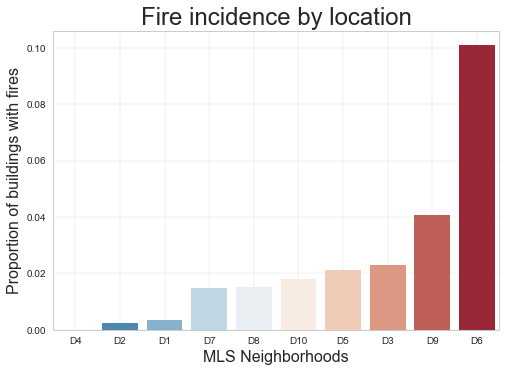

In [49]:
sns.set_style("whitegrid")
ax = sns.barplot(x="variable", y="value", 
                 data=neighbourhoods_l,
                 palette="RdBu_r")
plt.title('Fire incidence by location', fontsize = 24)
plt.xlabel('MLS Neighborhoods', fontsize = 16)
plt.ylabel('Proportion of buildings with fires', fontsize = 16)
ax.grid(color='gray', linestyle='-', linewidth=0.1)
#ax.set_xticklabels('')
plt.show()

In [112]:
prop_type= main_df[['BuildingFire_fire_incidents',
 'prop_code_A',
 'prop_code_CO',
 'prop_code_DA',
 'prop_code_DD',
 'prop_code_DF',
 'prop_code_F',
 'prop_code_FA',
 'prop_code_F2',
 'prop_code_OA',
 'prop_code_TIA',
 'prop_code_TIF',
 'prop_code_XV']].groupby('BuildingFire_fire_incidents').agg('sum').apply(lambda r: r/r.sum(), axis=0)
prop_type.reset_index(inplace=True)
prop_type.columns = ['Fire incidence',
'Apartment',
'Coop', 
'Dwellings - Apartments',
'2 Dwellings', 
'1 Flat & Dwelling',
'Flats & Duplex',
'1 Flat & 1 Apt Bldg',
'Flat & Store',
'Office and Apartments',
'TI Apartment',
'TI Flats & Duplex',
'Single Struct on Multi Lot']

prop_type_l =pd.melt(prop_type, id_vars=['Fire incidence'])
prop_type_l=prop_type_l[prop_type_l['Fire incidence']==1].sort_values(['value'], 
                                                                                     ascending=True).reset_index(drop=True)


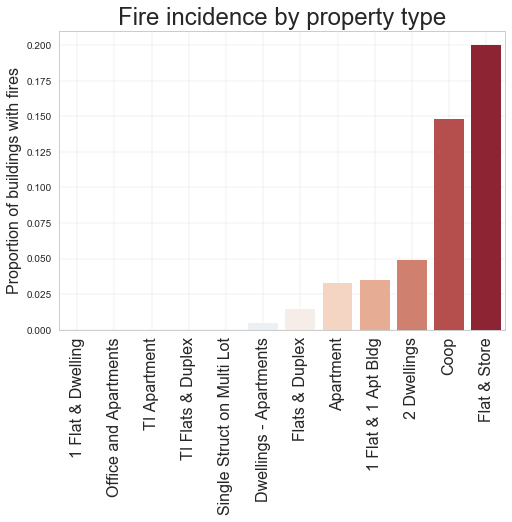

In [117]:
sns.set_style("whitegrid")
ax = sns.barplot(x="variable", y="value", 
                 data=prop_type_l,
                 palette="RdBu_r")
plt.title('Fire incidence by property type', fontsize = 24)
plt.xlabel('', fontsize = 16)
plt.ylabel('Proportion of buildings with fires', fontsize = 16)
ax.grid(color='gray', linestyle='-', linewidth=0.1)
xlabels=prop_type_l['variable']
ax.set_xticklabels(xlabels,fontsize=16, rotation=90)
#ax.set_xticklabels('')
plt.show()

In [58]:
prop_improvements= main_df[['BuildingFire_fire_incidents',
 'Interest Amount_fire_insp']].groupby('BuildingFire_fire_incidents').agg('mean')
prop_improvements.reset_index(inplace=True)
prop_improvements.columns=["Fire incidence", "Interest paid on violations"]

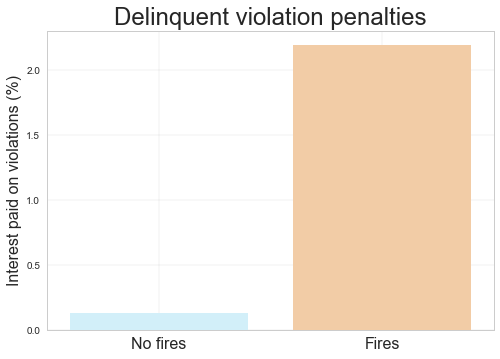

In [60]:
sns.set_style("whitegrid")
ax = sns.barplot(x="Fire incidence", y="Interest paid on violations", 
                  data=prop_improvements, palette=[ "#ccf2ff","#ffcc99"])
plt.title('Delinquent violation penalties', fontsize = 24)
plt.xlabel('', fontsize = 16)
plt.ylabel('Interest paid on violations (%)', fontsize = 16)
ax.grid(color='gray', linestyle='-', linewidth=0.1)
xlabels=['No fires', 'Fires']
ax.set_xticklabels(xlabels, fontsize=16)
plt.show()

In [108]:
prop_improvements= main_df[['BuildingFire_fire_incidents',
 'Closed Roll Assessed Land Value']].groupby('BuildingFire_fire_incidents').agg('median')
prop_improvements.reset_index(inplace=True)
prop_improvements.columns=["Fire incidence", "Land Value"]

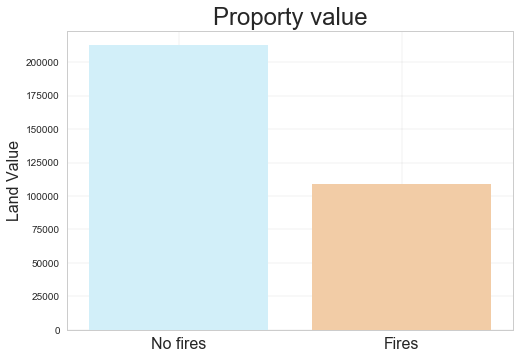

In [109]:
sns.set_style("whitegrid")
ax = sns.barplot(x="Fire incidence", y="Land Value", 
                  data=prop_improvements, palette=[ "#ccf2ff","#ffcc99"])
plt.title('Proporty value', fontsize = 24)
plt.xlabel('', fontsize = 16)
plt.ylabel('Land Value', fontsize = 16)
ax.grid(color='gray', linestyle='-', linewidth=0.1)
xlabels=['No fires', 'Fires']
ax.set_xticklabels(xlabels, fontsize=16)
plt.show()